In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] =False
from tqdm import tqdm

In [2]:
df = pd.read_csv('C:/Users/user/github/Data/energy/train.csv', encoding='cp949')

In [3]:
df.date_time = pd.to_datetime(df.date_time)

In [4]:
df_1 = df[df['num']==1]

In [150]:
df_1

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2035,1,2020-08-24 19:00:00,8714.952,29.4,3.4,66.0,0.0,0.2,0.0,0.0
2036,1,2020-08-24 20:00:00,8740.224,28.7,1.9,69.0,0.0,0.0,0.0,0.0
2037,1,2020-08-24 21:00:00,8730.504,28.3,1.1,71.0,0.0,0.0,0.0,0.0
2038,1,2020-08-24 22:00:00,8725.968,28.3,2.4,72.0,0.0,0.0,0.0,0.0


In [152]:
df_1 = df_1.set_index(['date_time'])

<AxesSubplot: xlabel='date_time'>

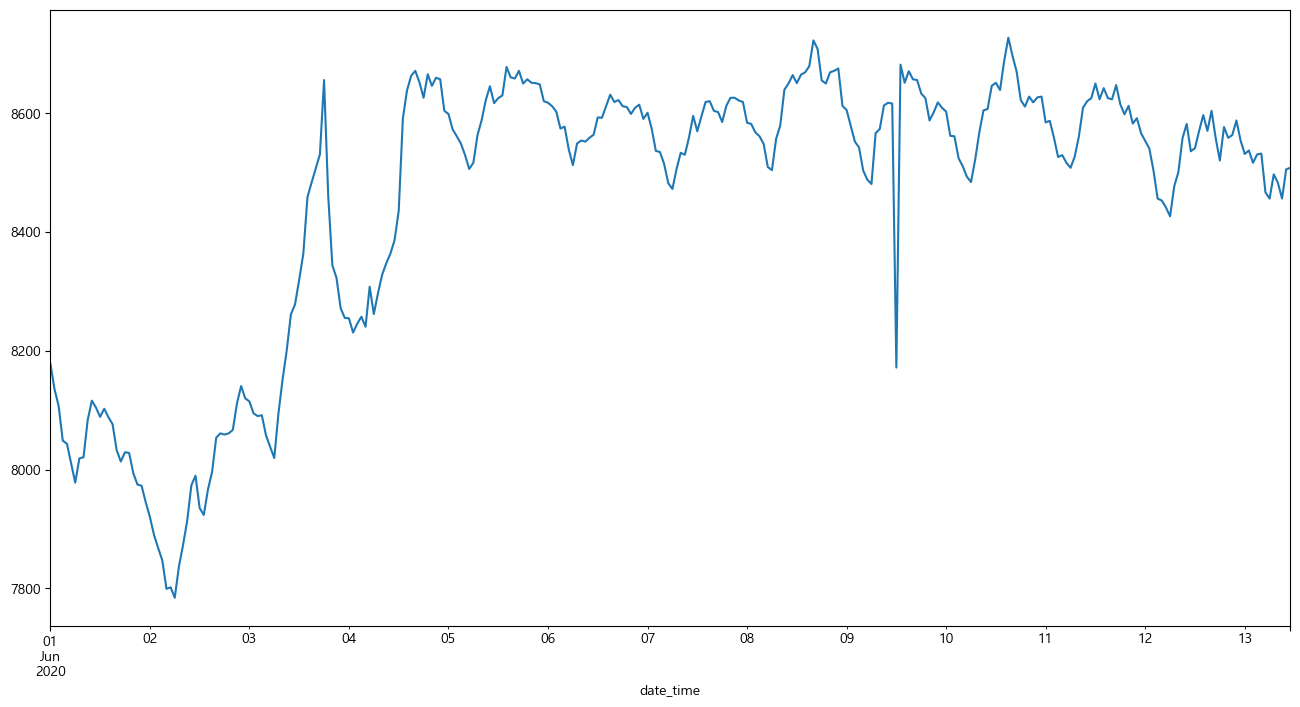

In [158]:
df_1.iloc[:300,1].plot(figsize=(16,8))

<AxesSubplot: >

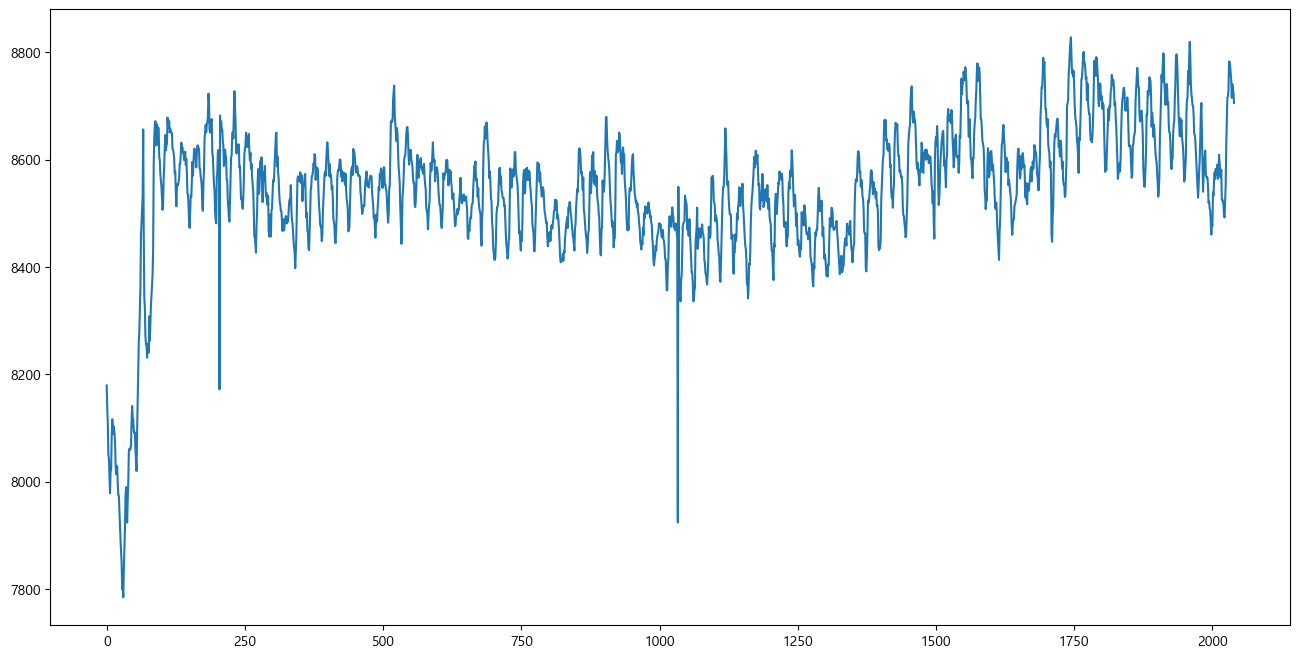

In [142]:
df_1['전력사용량(kWh)'].plot(figsize=(16,8))

In [6]:
group = df.groupby(['num','date_time']).mean()

<AxesSubplot: xlabel='num', ylabel='전력사용량(kWh)'>

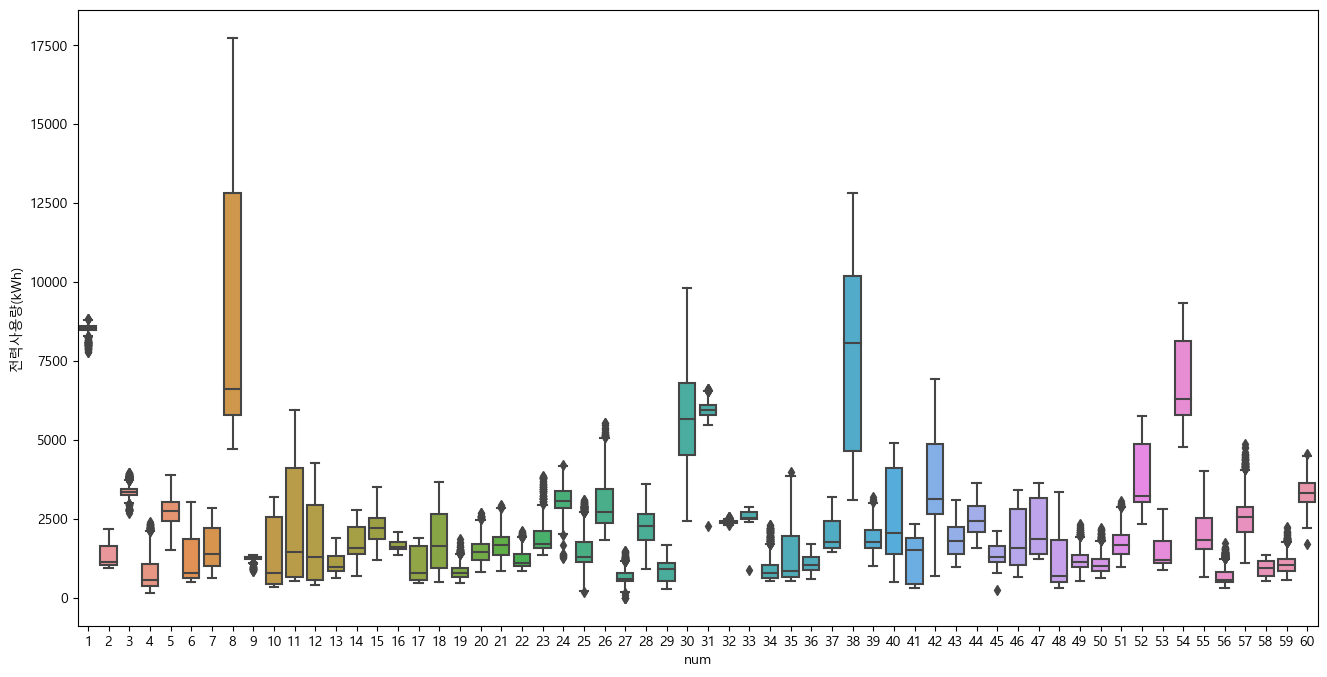

In [7]:
plt.figure(figsize=(16,8))
sns.boxplot(x='num', y='전력사용량(kWh)', data=df)

<AxesSubplot: xlabel='date_time', ylabel='전력사용량(kWh)'>

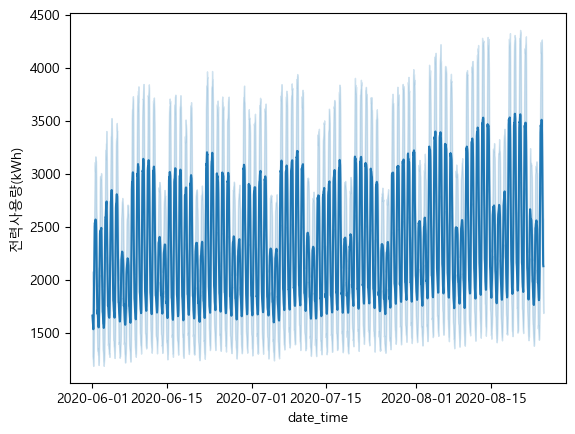

In [9]:
sns.lineplot(x='date_time', y='전력사용량(kWh)', data = df.groupby(['num','date_time']).mean())

In [62]:
eda_df = df.copy()

In [63]:
eda_df['month'] = 0
eda_df['hour'] = 0
eda_df['year'] = 0
eda_df['day'] = 0
eda_df['요일'] = 0

In [64]:
import datetime

In [65]:
days = ['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일']

In [66]:
for i in tqdm(range(len(eda_df))):
    eda_df['month'][i] = eda_df.date_time[i].month
    eda_df['hour'][i] = eda_df.date_time[i].hour
    eda_df['year'][i] = eda_df.date_time[i].year
    eda_df['day'][i] = eda_df.date_time[i].day
    eda_df['요일'][i] = days[eda_df.date_time[i].weekday()]

100%|██████████| 122400/122400 [03:20<00:00, 610.14it/s]


In [67]:
eda_df.요일.value_counts()

월요일    18720
화요일    17280
수요일    17280
목요일    17280
금요일    17280
토요일    17280
일요일    17280
Name: 요일, dtype: int64

In [139]:
eda_df[(eda_df['num'] == 1) & (eda_df['요일'] == '월요일')].head(48)

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,month,hour,year,day,요일
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,6,0,2020,1,월요일
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,6,1,2020,1,월요일
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,6,2,2020,1,월요일
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,6,3,2020,1,월요일
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,6,4,2020,1,월요일
5,1,2020-06-01 05:00:00,8010.576,16.9,3.4,93.0,0.0,0.0,0.0,0.0,6,5,2020,1,월요일
6,1,2020-06-01 06:00:00,7978.176,16.7,3.4,90.0,0.1,0.0,0.0,0.0,6,6,2020,1,월요일
7,1,2020-06-01 07:00:00,8019.000,16.9,2.3,86.0,0.0,0.1,0.0,0.0,6,7,2020,1,월요일
8,1,2020-06-01 08:00:00,8020.944,17.8,3.3,80.0,0.0,0.3,0.0,0.0,6,8,2020,1,월요일
9,1,2020-06-01 09:00:00,8083.152,19.3,2.1,73.0,0.0,0.7,0.0,0.0,6,9,2020,1,월요일


In [69]:
input = eda_df.drop(['기온(°C)','풍속(m/s)','습도(%)','강수량(mm)','일조(hr)','비전기냉방설비운영','태양광보유','month'], axis=1)

In [70]:
input

,num,date_time,전력사용량(kWh),hour,year,day,요일
0,1,2020-06-01 00:00:00,8179.056,0,2020,1,월요일
1,1,2020-06-01 01:00:00,8135.640,1,2020,1,월요일
2,1,2020-06-01 02:00:00,8107.128,2,2020,1,월요일
3,1,2020-06-01 03:00:00,8048.808,3,2020,1,월요일
4,1,2020-06-01 04:00:00,8043.624,4,2020,1,월요일
...,...,...,...,...,...,...,...
122395,60,2020-08-24 19:00:00,4114.368,19,2020,24,월요일
122396,60,2020-08-24 20:00:00,3975.696,20,2020,24,월요일
122397,60,2020-08-24 21:00:00,3572.208,21,2020,24,월요일
122398,60,2020-08-24 22:00:00,3299.184,22,2020,24,월요일


In [95]:
mean = pd.DataFrame(input.groupby(['num','요일','hour']).mean()['전력사용량(kWh)'])

In [96]:
std = pd.DataFrame(input.groupby(['num','요일','hour']).std()['전력사용량(kWh)'])

In [102]:
total_df = pd.merge(mean, std, how='inner', left_on = ['num','요일','hour'], right_on=['num','요일','hour'])

In [105]:
total_df.reset_index(inplace=True)

In [123]:
total_df.columns = ['num' ,'요일', 'hour', 'mean', 'std']

In [141]:
total_df.head(48)

,num,요일,hour,mean,std
0,1,금요일,0,8560.674,72.503094
1,1,금요일,1,8539.398,73.388010
2,1,금요일,2,8524.980,75.023042
3,1,금요일,3,8507.646,72.510991
4,1,금요일,4,8493.390,69.498200
5,1,금요일,5,8471.034,74.132219
6,1,금요일,6,8465.634,76.823163
7,1,금요일,7,8495.172,70.522925
8,1,금요일,8,8517.798,72.983080
9,1,금요일,9,8566.614,76.581458


<AxesSubplot: >

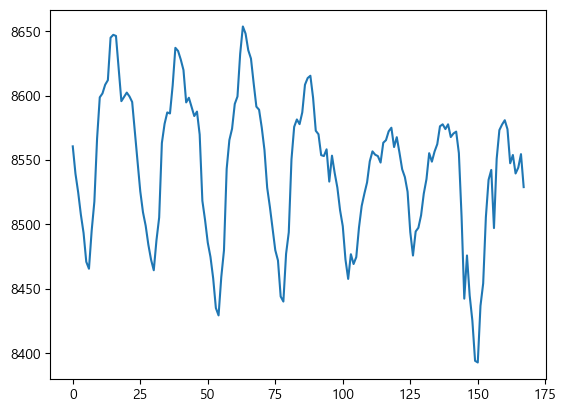

In [121]:
total_df[total_df['num'] == 1].iloc[:,3].plot()

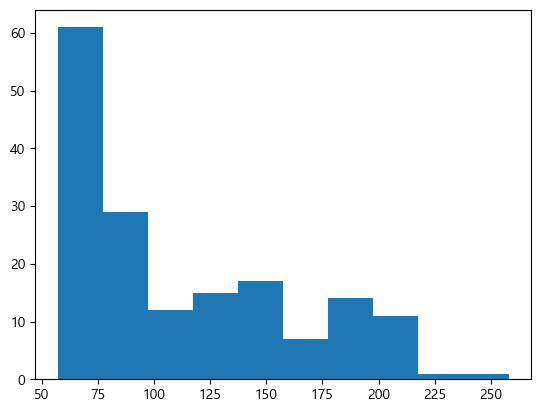

In [175]:
plt.hist(total_df[total_df['num'] == 1].iloc[:,4], histtype='stepfilled')
plt.show()

In [108]:
from scipy.stats import norm 

In [169]:
np.random.normal(5, 1, 50000)

array([5.69405507, 3.86272589, 7.21899117, ..., 5.43076581, 3.98157436,
       5.57583687])

In [116]:
total_df[total_df['num'] == 1].iloc[0,3]

8560.674

In [164]:
norm.pdf(total_df[total_df['num'] == 1].iloc[:,3] , total_df[total_df['num'] == 1].iloc[0,4])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
plt.plot()

In [ ]:
# 예측 모형
def predict(data, mean, std):
    # 각 시간마다 평균값과 분산을 다르게 설정
    predicted_values = []
    for i in range(len(data)):
        # 각 시간마다 평균값과 분산 설정
        mu_i = mean[i % 12]
        std_i = std[i % 12]

        # 예측값 계산
        y_i = np.random.normal(mu_i, std_i)
        predicted_values.append(y_i)

    return predicted_values

# 예측값 출력
#predicted_values = predict(data)

In [ ]:
num_1 = predict(eda_df[eda_df['num']==1]['전력사용량(kWh)'], mean[1], std[1])

<Axes: >

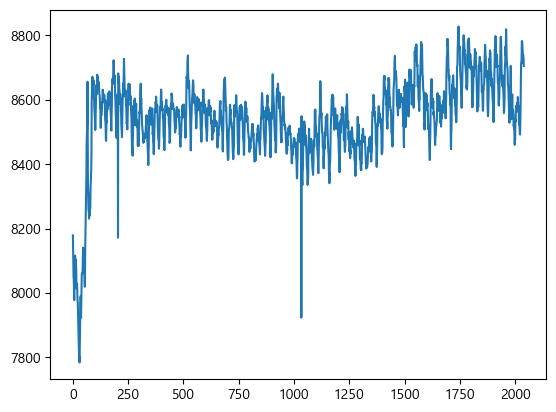

In [ ]:
eda_df[eda_df['num']==1]['전력사용량(kWh)'].plot()

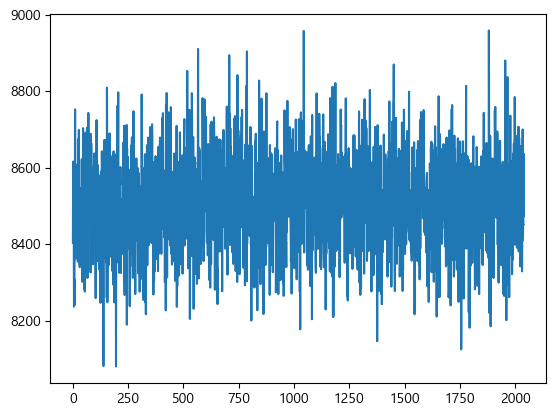

In [ ]:
plt.plot(num_1)